## Colab Installation

Run the following code block if you are using this Jupyter notebook in Google Colab. Otherwise skip to importing the packages.

In [ ]:
# Run these statements if you are using Google Colab. Otherwise skip this step.
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
# figpath = '' #this path sends the figures to the directory that you want
# savefigs = True  #save the figures on your disk if True
# imgfrmt = 'pdf' #kind of format to save figures as

# Definitions of Python Functions

The following functions are things that will be repeatedly used in the notebook so that there isn't duplicate code all over the place.

## Graphing Functions

The following functions are to help with graphing.

In [2]:
def make_grid(d=3, nper=2):
    """this function creates a nper^d x d matrix of grid points"""
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  # array of coordinate values
    xgrid = xpts  # initial grid
    n = nper  # initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  # store the old grid
        xgrid = np.vstack((xgrid0, xpts[0] * np.ones((1, n))))  # stack the next coordinate
        for jj in range(1, nper):
            xgrid = np.hstack((xgrid, np.vstack((xgrid0, xpts[jj] * np.ones((1, n))))))
        n = n * nper  # update the length of the grid
    return xgrid.T  # take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot=[0, 1], savefig=True, figpath=''):
    """Plots a dot grid."""
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot, [d, d]), # ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot, [1, 1]), # ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False)
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]), fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]), fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath + f"{n:.0f}gridpts_d{d:.0f}." + imgfrmt, format=imgfrmt)


In [3]:
def graph_kernel(bandwidths, lin_spaces, kernel, ylim_lst=[-0.05, 1.2]):
  """Graphs a given kernel, with given bandwidths, lin_spaces
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points"""
  ypts = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  nband = len(bandwidths)
  fig, ax = plt.subplots(1, 3, figsize=(5*nband, 5))
  for ii in range(nband):
      ax[ii].plot(ypts,kernel(ypts/bandwidths[ii]) / bandwidths[ii])
      ax[ii].grid(False)
      ax[ii].set_ylim(ylim_lst)
      ax[ii].set_xlabel(r'$y$', fontsize=20)
      ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   if (ii == 0):
    #       ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   else:
    #       ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)

In [4]:
def generate_sobol_iid_graph(bandwidths, lin_spaces, kde, kernel, yiid, ysob, ylim_lst=[-0.05, 1.2]):
  """Generates a graph using IID and Sobol sample points.
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points
  kde = name of kde function
  kernel = name of kernel function
  yiid = set of iid points
  ysob = set of LD points generated with sobol sequence"""
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  for ii in range(nband):
      rhovaliid = kde(kernel, yiid, bandwidths[ii], yeval)
      rhovalsob = kde(kernel, ysob, bandwidths[ii], yeval)
      fig,ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

In [5]:
def generate_graphs(bandwidths, lin_spaces, kde, kernel, sample_points, ylim_lst=[-0.05, 1.2]):
  """
  Generate graphs involving a kde, kernel, and sample_points.
  sample_points is a list of IID, Sobol, Lattice, DNB2, and Halton points.
  """
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  rho_list = list()
  for ii in range(nband):
      rhovaliid = kde(kernel, sample_points[0], bandwidths[ii], yeval)
      rhovalsob = kde(kernel, sample_points[1], bandwidths[ii], yeval)
      rhovallattice = kde(kernel, sample_points[2], bandwidths[ii], yeval)
      rhovaldnetb2 = kde(kernel, sample_points[3], bandwidths[ii], yeval)
      rhovalhalton = kde(kernel, sample_points[4], bandwidths[ii], yeval)
      fig, ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.plot(yeval, rhovallattice, label = "Lattice")
      ax.plot(yeval, rhovaldnetb2, label = "Digital Net B2")
      ax.plot(yeval, rhovalhalton, label = "Halton")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

## Generate Functions

The following functions are used to generate different types of sample points.

In [6]:
def gen_iid_and_sobol(dimen = 3, n = 2**12):
  """Generate IID and Sobol sample points based on given sample size and dimensions."""
  coord_wts = 2.0 ** (-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  return (iidpts, sobpts)

def gen_iid_ld_pts(dimen = 3, n = 2**12):
  """
  Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
  based on dimension and smaple size.
  """
  coord_wts = 2.0**(-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  latticepts = qp.Lattice(dimen).gen_samples(n)
  dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
  haltonpts = qp.Halton(dimen).gen_samples(n)
  return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

## Generating Points

Generating sequences of IID and LD points, with dimensions 1 and 3.

In [7]:
# dim = 1, n = 2**12
iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**12)
# print("iid: ", iidpts1)
# print("sobol: ", sobpts1)
# print("lattice: ", latticepts1)
# print("digital net B2: ", dnetb2pts1)
# print("halton: ", haltonpts1)

In [8]:
# dim = 3, n = 2**12
iidpts3, sobpts3, latticepts3, dnetb2pts3, haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**12)
# print("iid: ", iidpts3)
# print("sobol: ", sobpts3)
# print("lattice: ", latticepts3)
# print("digital net B2: ", dnetb2pts3)
# print("halton: ", haltonpts3)

## Kernels and KDEs

The following are definitions of different kernels used in the notebook. Some may be defined later, but these are ones used throughout the notebook or commonly used/known.

The gaussian kernel defined below represents the following:

$$
\frac{e^{-y^2}}{\sqrt{\pi}}
$$

In [15]:
def kernel(y):
    return np.exp(-y * y) / np.sqrt(np.pi)

#### Generate some $y_i=f(x_i)$ points
$
f(\mathbf{x}) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [9]:
def testfun1(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [10]:
yiid1 = testfun1(iidpts1)
ysob1 = testfun1(sobpts1)

yiid3 = testfun1(iidpts3)
ysob3 = testfun1(sobpts3)

The following *Kernel Density Estimator* (KDE)

$$
\varrho() = \frac{k\left(\frac{y - Y}{h}\right)}{h}
$$

*(Still needs work.)*

In [45]:
def kde(kernel, ypts, bandwidth, yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / bandwidth)) / bandwidth
    return rhoval

In [32]:
kernel_vec = np.vectorize(kernel)

In [46]:
def kde_vec(kernel_vec, ypts, bandwidth, yeval):
    return np.mean(kernel_vec((yeval-ypts) / bandwidth)) / bandwidth

In [53]:
# yiid1 = ypts (4096 elements)
# yeval = np.linspace(-4, 8, 500) (500 elements)
yeval=np.linspace(-4, 8, 500)
print(yeval.shape)
ypts = yiid1
print(ypts.shape)

(500,)
(4096,)


In [56]:
ypts

array([1.54629502, 5.84868202, 1.922304  , ..., 4.96061605, 2.50793404,
       2.45864467])

In [58]:
yeval[0]

-4.0

In [57]:
yeval[0]-ypts

array([-5.54629502, -9.84868202, -5.922304  , ..., -8.96061605,
       -6.50793404, -6.45864467])

In [61]:
kernel_vec((yeval[0] - ypts))

array([2.46560669e-14, 4.23023047e-43, 3.30458839e-16, ...,
       7.59931709e-36, 2.27856619e-19, 4.31743217e-19])

In [62]:
kernel(yeval[0]-ypts)

array([2.46560669e-14, 4.23023047e-43, 3.30458839e-16, ...,
       7.59931709e-36, 2.27856619e-19, 4.31743217e-19])

In [60]:
rhoval = np.zeros_like(yeval) #values of density estimator
for ii in range(len(yeval)):
    rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / 0.1)) / 0.1
print(rhoval)
print(rhoval.shape)

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 7.65801751e-321 3.22688660e-315
 1.21345852e-309 4.06494904e-304 1.21303893e-298 3.22466334e-293
 7.63632832e-288 1.610927

In [47]:
# dim = 1, n = 2**12
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde_vec, kernel_vec, yiid1, ysob1)

ValueError: operands could not be broadcast together with shapes (500,) (4096,) 

## Hermite Kernel

The following comes from Dr. Hickernell's KDE experiment notebook.


In [17]:
# Original hermite kernel function from Dr. Hickernell
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
def sy_hermite_kernel(y = sy.symbols('y', real = True), band_width = sy.symbols('h', positive = True), r = 1, only_coef = False):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    
#    import sympy as sy
    wt = sy.exp(-y*y) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
            # to hardcode the above line:
            # r = 0: intk[jj, ii] = (np.exp(-y**2))/((math.pi)**0.5)
            # r = 1: intk[jj, ii] = ((3-2*y**2)*np.exp(-y**2))/(2*(math.pi)**0.5)
            # r = 2: intk[jj, ii] = ((4*y**4 - 20*y**2 +15)*np.exp(-y**2))/(8*(math.pi)**0.5)
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ..., y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
    if only_coef:
        return coef
    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width) #form the isotropic kernel and insert the bandwidth dependency
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [18]:
# testing original hermite kernel function

test_kernel_sy = sy_hermite_kernel(r=1) # r = number terms in kernel
print(type(test_kernel_sy))
print('kernel =',test_kernel_sy)
integ = sy.integrate(test_kernel_sy,(y,-sy.oo,sy.oo))
print('integ =',integ) # should be 1
test_kernel_sy = sy_hermite_kernel(r=1,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=2,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=3,only_coef = True)
print(test_kernel_sy)

Matrix([[1/sqrt(pi)]])
<class 'sympy.core.mul.Mul'>
kernel = exp(-y**2/h**2)/(sqrt(pi)*h)
integ = 1
Matrix([[1/sqrt(pi)]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])


In [19]:
# hardcoding hermite kernel coefficients

def hardcode_hermite_kernel(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return sy.Matrix([[1/(math.pi)**0.5]])
    elif r==1:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# Coefficients: 
# r = 0 (corresponds to r = 1 from original function): Matrix([[1/sqrt(pi)]])
# r = 1 (corresponds to r = 2 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
# r = 2 (correpsonds to r = 3 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])

In [20]:
# testing hardcoded hermite kernel

test_kernel = hardcode_hermite_kernel(r=0) # r = number terms in kernel
print(type(test_kernel))
print('kernel =',test_kernel)
test_kernel = hardcode_hermite_kernel(r=1)
print(test_kernel)
test_kernel = hardcode_hermite_kernel(r=2)
print(test_kernel)

<class 'sympy.matrices.dense.MutableDenseMatrix'>
kernel = Matrix([[0.564189583547756]])
Matrix([[0.564189583547756, -0.141047395886939]])
Matrix([[0.564189583547756, -0.141047395886939, 0.0176309244858674]])


Matrix([[1/sqrt(pi)]])
ktilde = \frac{e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
ktilde = \frac{\left(\frac{3}{2} - y^{2}\right) e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])
ktilde = \frac{\left(4 y^{4} - 20 y^{2} + 15\right) e^{- y^{2}}}{8 \sqrt{\pi}}


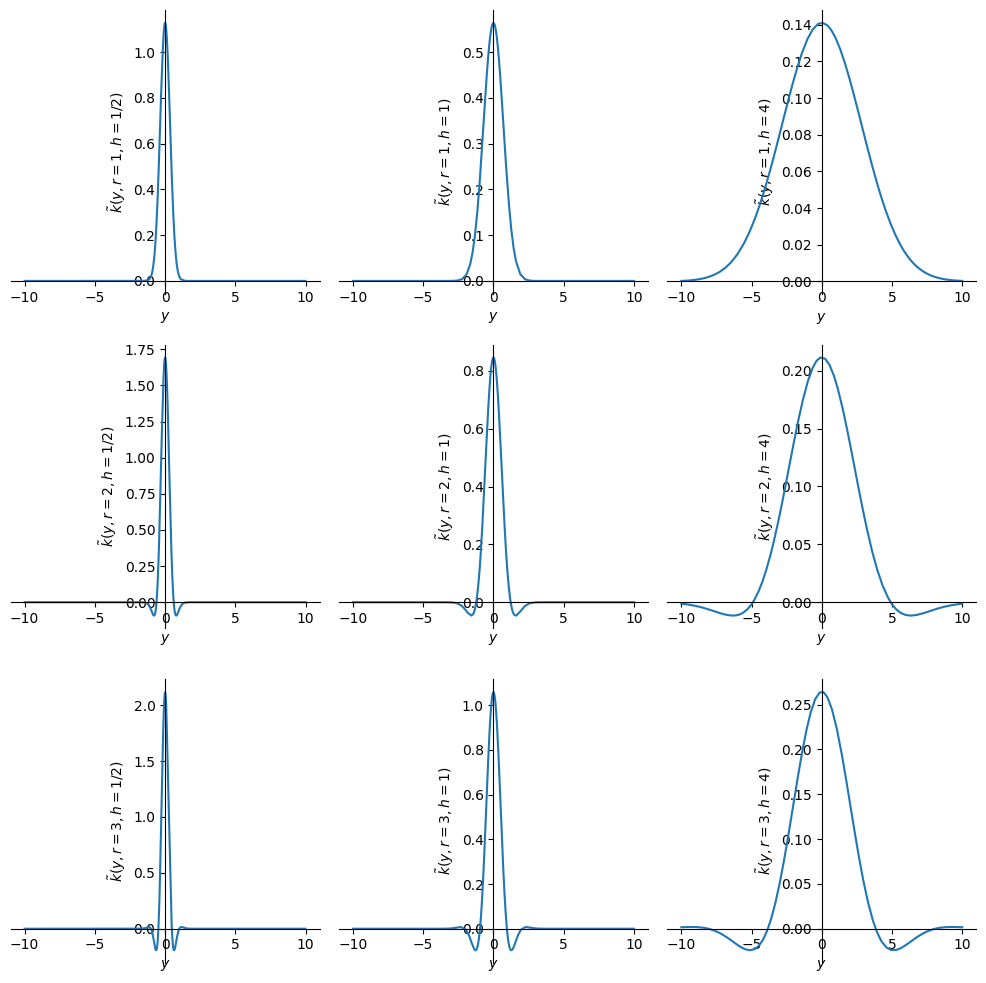

In [21]:
# visualizing hermite kernel
# Notes: smaller bandwidth = spikier kernel; higher order = more accurate, but KDE might have negative values

h = sy.symbols('h', positive = True)
y = sy.symbols('y', real = True)
rarray = sy.Matrix([sy.Integer(1), sy.Integer(2), sy.Integer(3)])
nr = rarray.shape[0]

harray = sy.Matrix([sy.Rational(1/2), sy.Rational(1), sy.Rational(4)]) # Rational() returns rational form of value--diff. bandwidths
nh = harray.shape[0] # number of bandwidths
p = []; # plots
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy.simplify(sy_hermite_kernel(y,h,rval))
    print('ktilde =',sy.latex(ktilde_sy.subs(h,1)))
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(ktilde_sy.subs(h,hval),ylabel = r'$\tilde k(y,r='+str(rval)+',h='+str(hval)+')$', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));

In [22]:
# original function: define hermite kernel for r = 1 (corresopnds to r = 0 in the hardcoded case)
def hermite_kernel(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [23]:
# hardcoded: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [24]:
# original: define hermite kernel for r = 2 (corresopnds to r = 1 in the hardcoded case)
def hermite_kernel_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0) # why use the 0th polynomial?
    # print(poly)
    # for i in range(len(coef[0])):
    #     print(coef[0][i])
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [25]:
# hardcoded: define hermite kernel for r = 1 (corresponds to r = 2 in the original case)
def hardcode_hermite_kernel_weight_1(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [26]:
# hardcoded: define hermite kernel for r = 2 (corresponds to r = 3 in the original case)
def hardcode_hermite_kernel_weight_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [27]:
# example hermite kernel
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hermite_kernel(y,r=1)
print(type(k))
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]


In [28]:
# example hardcoded hermite kernel
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hardcode_hermite_kernel_weight(y,r=0) # r=0 for hardcoded kernel corresponds to r=1 for original kernel
print(type(k))
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]


### Timing different versions of hermite kernel function

In [29]:
import time

In [30]:
# original hermite function
t1 = time.perf_counter(), time.process_time()
k = hermite_kernel(y,r=1)
print('k =',k)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]
 Real time: 0.03 seconds
 CPU time: 0.00 seconds


In [31]:
# hardcoded hermite function--seems to be faster than original, but how come graphing still takes so long?
t1 = time.perf_counter(), time.process_time()
k = hardcode_hermite_kernel_weight(y,r=0)
print('k =',k)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]
 Real time: 0.00 seconds
 CPU time: 0.00 seconds


In [ ]:
import pprofile

In [ ]:
# original hermite kernel function: Total duration: 0.526621s
# sy_hermite_kernel and sympy integration are taking the longest (look at output starting in line 113100)
profiler = pprofile.Profile()
with profiler:
    coef = np.array(sy.N(sy_hermite_kernel(r = 1, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,1):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2)
    print(k)
# profiler.dump_stats("profiler_stats.txt")
profiler.print_stats()

In [ ]:
# hardcoded hermite kernel function: Total duration: 0.0159254s (nothing really takes that long)
profiler = pprofile.Profile()
with profiler:
    coef = np.array((hardcode_hermite_kernel(r = 0)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,0):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    print(k)
# profiler.dump_stats("profiler_stats.txt")
profiler.print_stats()

In [ ]:
# original hermite graphs: 
profiler = pprofile.Profile()
with profiler:
    # original: dim = 1, r = 1
    ## hermite kernel takes much longer--why?
    bandwidth = [0.05, 0.1, 0.2]
    spaces = (-4, 8, 500)
    generate_sobol_iid_graph(bandwidth, spaces, kde, hermite_kernel, yiid1, ysob1)
# profiler.dump_stats("profiler_stats.txt")
profiler.print_stats()

In [ ]:
# hardcoded hermite graphs:
profiler = pprofile.Profile()
with profiler:
    bandwidth = [0.05, 0.1, 0.2]
    spaces = (-4, 8, 500)
    generate_sobol_iid_graph(bandwidth, spaces, kde, hardcode_hermite_kernel_weight, yiid1, ysob1)
# profiler.dump_stats("profiler_stats.txt")
profiler.print_stats()